# White Box Models for Pipelines


In [181]:
import pickle

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from white_box_single_pipeline import scan_branched_op
from white_box_single_pipeline import build_probe_op


# Use one of the following to create pdf files with the latex engine
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
# OR the following, which will not allow to use interactive backends
# mpl.use('pgf')

# set parameters to draw with latex engine
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 9,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
    ]
}
# apply latex engine, CAUTION does not work if data contains '_' (underscore)
mpl.rcParams.update(pgf_with_latex)

def figsize(scale=1, gm=3):                         # default golden mean =3.5
    fig_width_pt = 497.92325                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/gm           # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean*1              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size


def figsize3d(scale=1, gm=4):                         # default golden mean =3.5
    fig_width_pt = 497.92325                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/gm           # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean*1              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

fig_scale = 0.5

# Convert 2^x values to B / KiB / MiB
@ticker.FuncFormatter
def major_formatter(x, pos):
    x = 2**x * 1000 #convert from log2 kb to bytes
    if x < 1000:
        return "%.0f B" % x
    elif x < 1000*1000:
        return "%.0f kB" % (x/1000)
    elif x < 1000*1000*1000:
        return "%.0f MB" % (x/1000/1000)
    else:
        return "%.2f GB" % (float(x)/1000/1000/1000)
    

## 3D plots - 1a

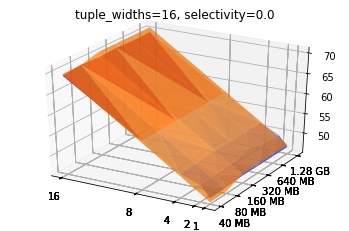

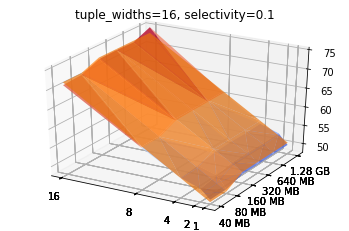

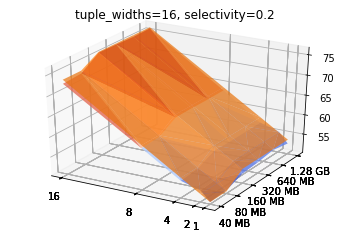

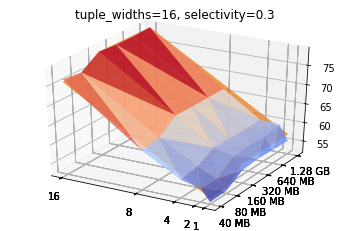

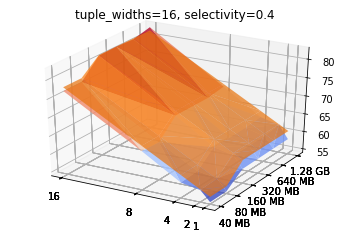

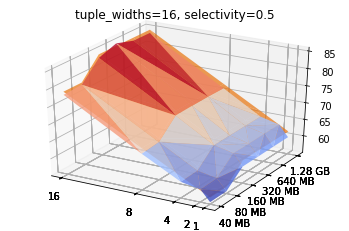

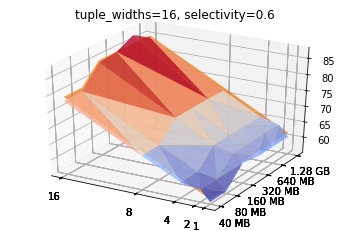

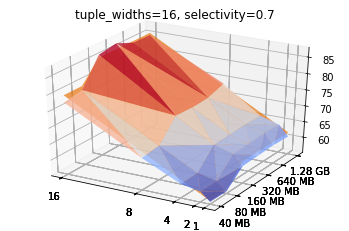

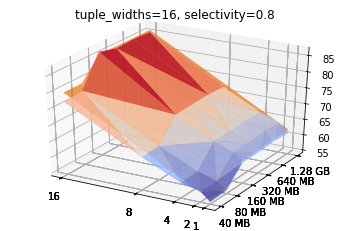

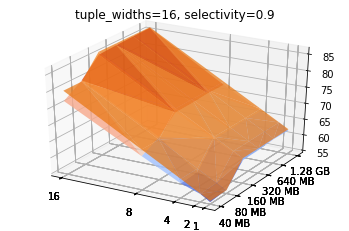

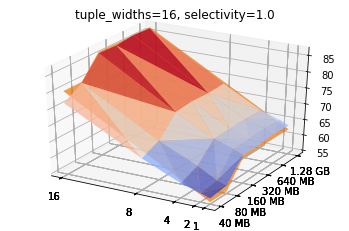

In [250]:
## from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

df = pd.read_csv("data/white_box/simple_sel_pipeline_smaller_tables.csv")

df['tupleaccess'] = (1000*df['runtime']) / df['tablerows']

with open('models/white_box/scan_40k_80k.pickle', 'rb') as handle:
    white_box_params_40_80 = pickle.load(handle)
    
with open('models/white_box/scan_larger_160k.pickle', 'rb') as handle:
    white_box_params_160 = pickle.load(handle)

def estimate_per_row(df_row, model):
    return scan_branched_op(params=model, selectivity=df_row['selectivity'], 
                            tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                            no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()

df['white_box_estimate'] = df.apply(lambda row: (estimate_per_row(row, white_box_params_40_80)) if row['tablesizekb'] < 160000 else (estimate_per_row(row, white_box_params_160)), axis=1)

df['estimated_tupleaccess'] = (1000*df['white_box_estimate']) / df['tablerows']

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()

# for ts in tablesizes:
# for tw in tuple_widths:
df_temp = df[df.tuplewidth == 16]
df_temp_big = df_temp[df_temp.tablesizekb >= 40000]
if len(df_temp_big.index) > 0:
    averaged_data = df_temp_big[['attrInPred', 'selectivity', 'tablesizekb', 'tupleaccess', 'white_box_estimate', 'estimated_tupleaccess']].groupby(['attrInPred', 'tablesizekb', 'selectivity']).mean().reset_index()
    selectivities = averaged_data['selectivity'].round(1).unique()
    for selectivity in selectivities[::1]:
        plot_data = averaged_data[averaged_data.selectivity == selectivity]
#         print(plot_data)
#         if (len(plot_data['attrInPred'].unique()) < 2):
#             continue
#         if (len(plot_data['tablesizekb'].unique()) < 2):
#             continue

        fig = plt.figure()
        ax = fig.gca(projection='3d')

        plt.title(f"tuple_widths={tw}, selectivity={selectivity}")
        X = plot_data['attrInPred']
        Y = plot_data['tablesizekb']
        Z = plot_data['tupleaccess']
        Z1 = plot_data['estimated_tupleaccess']
        
        ax.set_xticks(X)
        ax.set_yticks(np.log2(Y))
        ax.yaxis.set_major_formatter(major_formatter)
        Y = np.log2(Y)
        plt.gca().invert_xaxis()

#             print(plot_data)
        surf1 = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, alpha=0.8)
        surf2 = ax.plot_trisurf(X, Y, Z1, alpha=0.7)#, cmap=cm.summer)

        plt.show()
                
                

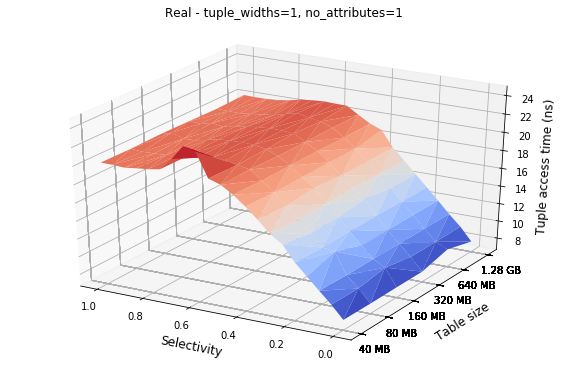

<Figure size 432x288 with 0 Axes>

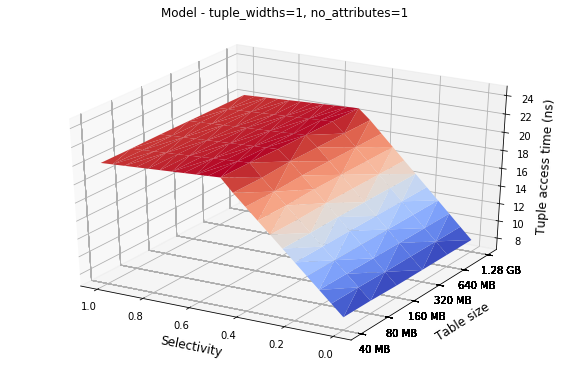

Mean Q Error: 1.0139627701186673


<Figure size 432x288 with 0 Axes>

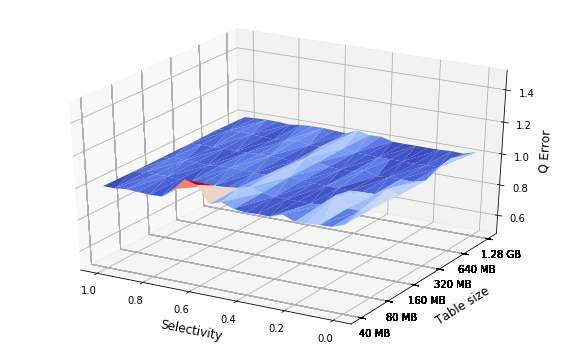

<Figure size 432x288 with 0 Axes>

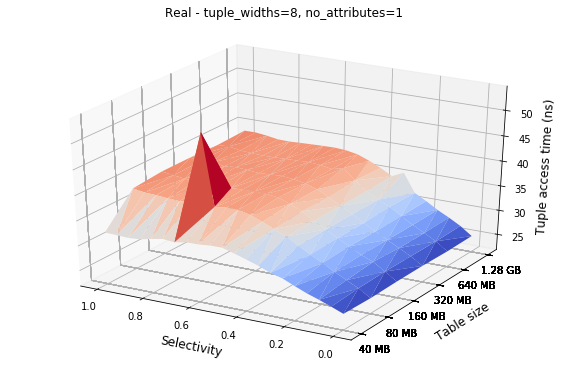

<Figure size 432x288 with 0 Axes>

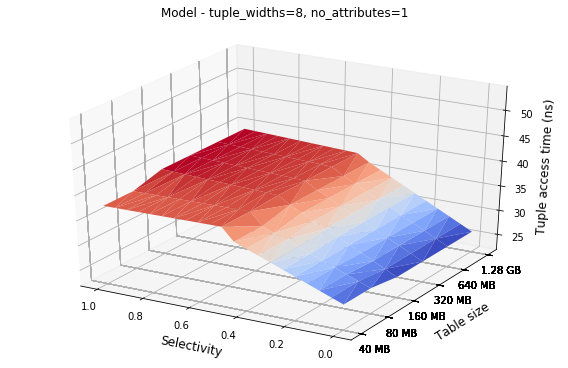

Mean Q Error: 1.0328271160014222


<Figure size 432x288 with 0 Axes>

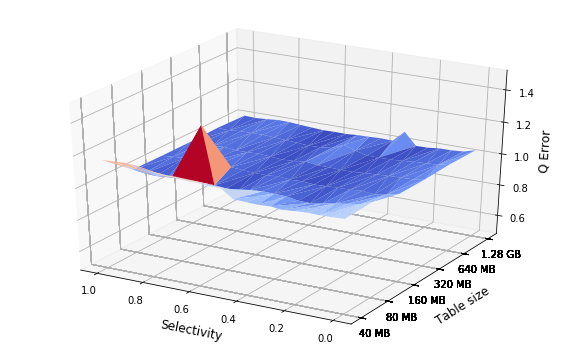

<Figure size 432x288 with 0 Axes>

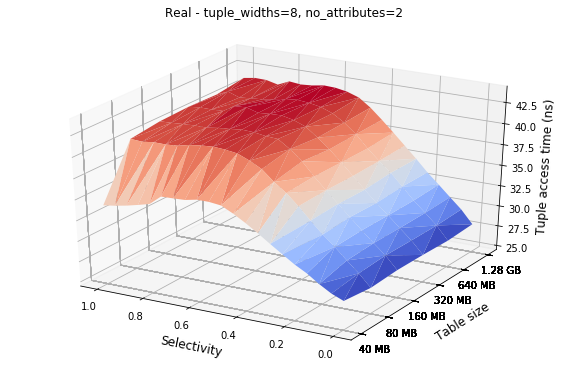

<Figure size 432x288 with 0 Axes>

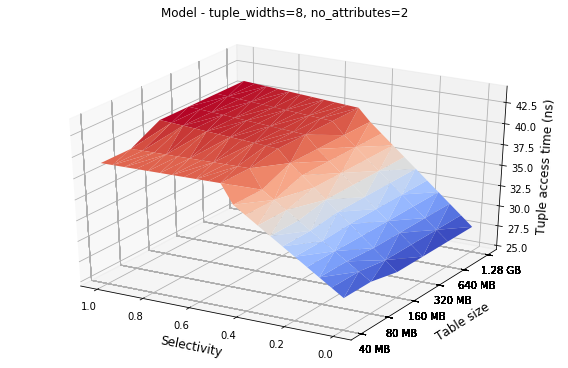

Mean Q Error: 1.033376161656921


<Figure size 432x288 with 0 Axes>

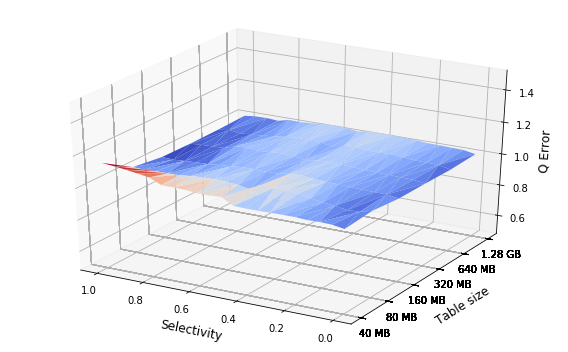

<Figure size 432x288 with 0 Axes>

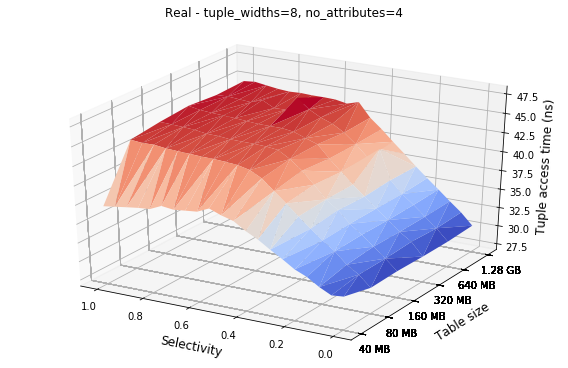

<Figure size 432x288 with 0 Axes>

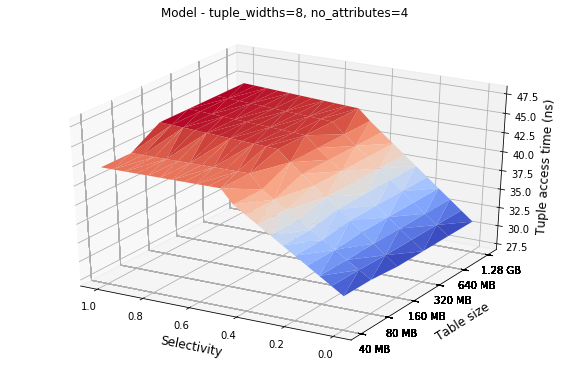

Mean Q Error: 1.0223572851456773


<Figure size 432x288 with 0 Axes>

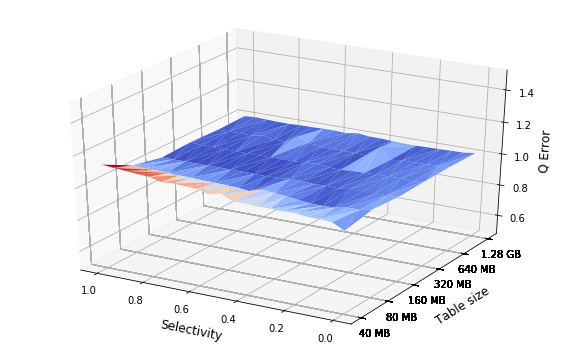

<Figure size 432x288 with 0 Axes>

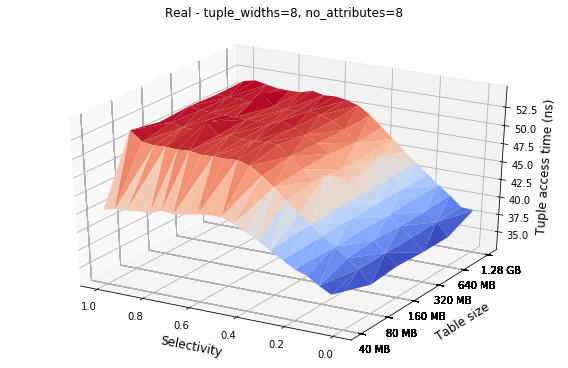

<Figure size 432x288 with 0 Axes>

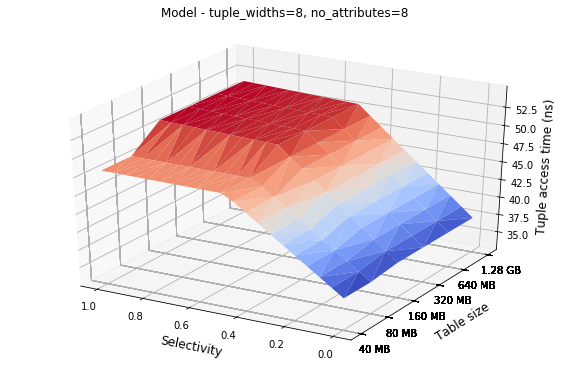

Mean Q Error: 1.0214088917915711


<Figure size 432x288 with 0 Axes>

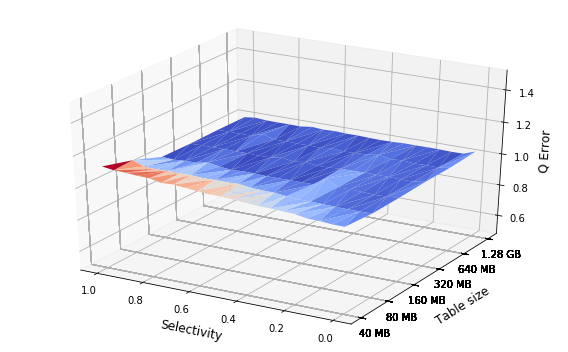

<Figure size 432x288 with 0 Axes>

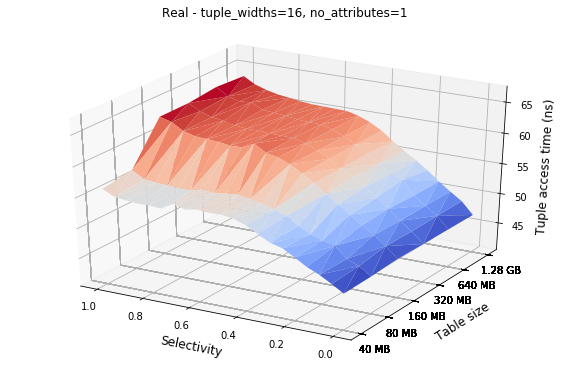

<Figure size 432x288 with 0 Axes>

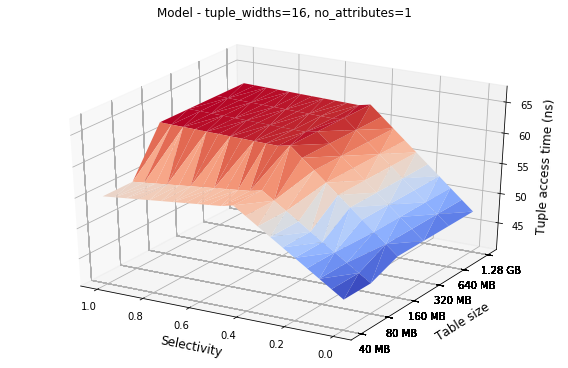

Mean Q Error: 1.019131247433967


<Figure size 432x288 with 0 Axes>

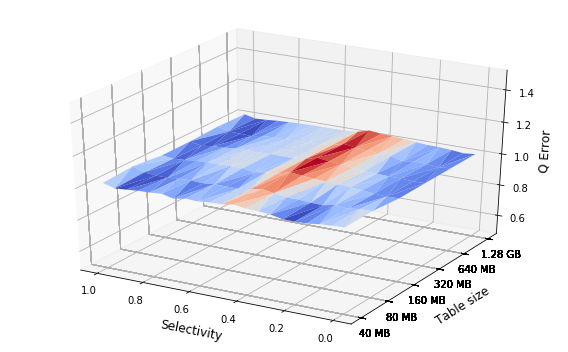

<Figure size 432x288 with 0 Axes>

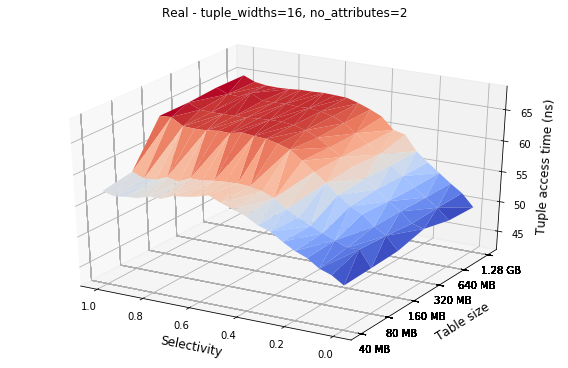

<Figure size 432x288 with 0 Axes>

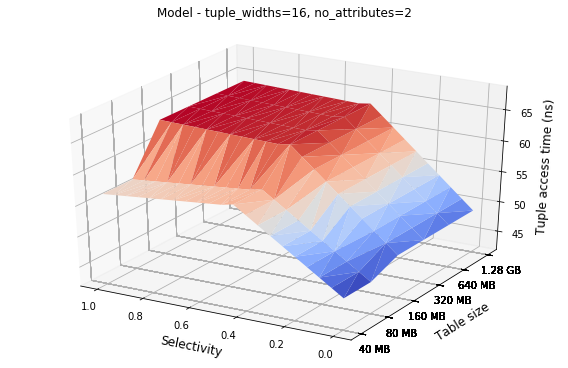

Mean Q Error: 1.0106984239788992


<Figure size 432x288 with 0 Axes>

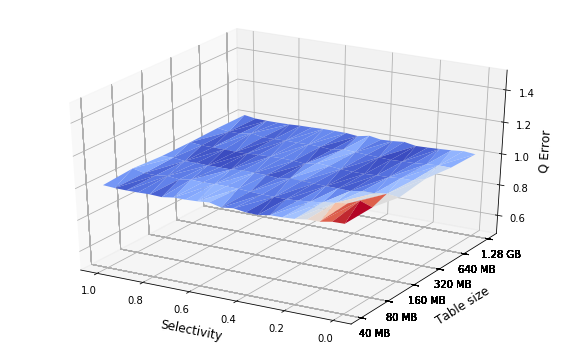

<Figure size 432x288 with 0 Axes>

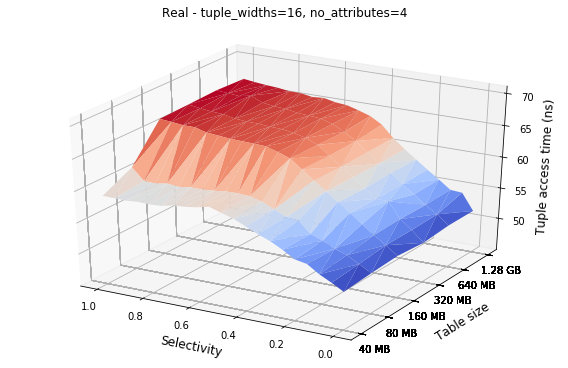

<Figure size 432x288 with 0 Axes>

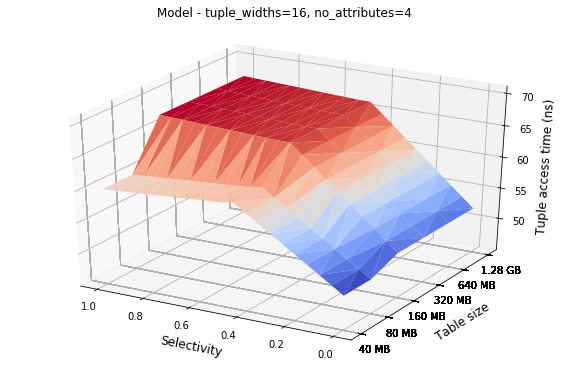

Mean Q Error: 1.0193122862737987


<Figure size 432x288 with 0 Axes>

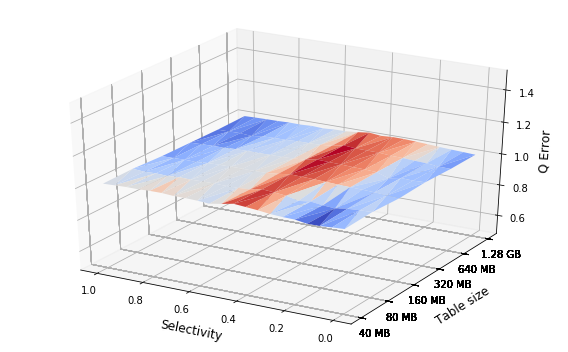

<Figure size 432x288 with 0 Axes>

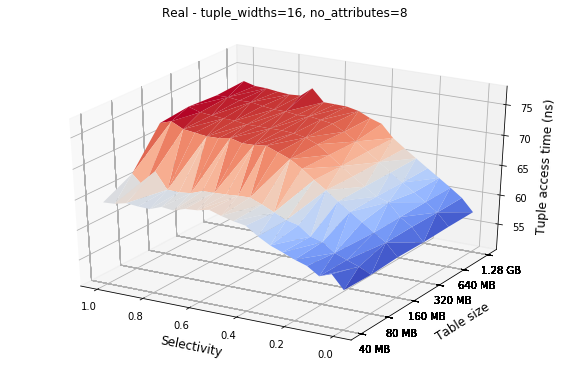

<Figure size 432x288 with 0 Axes>

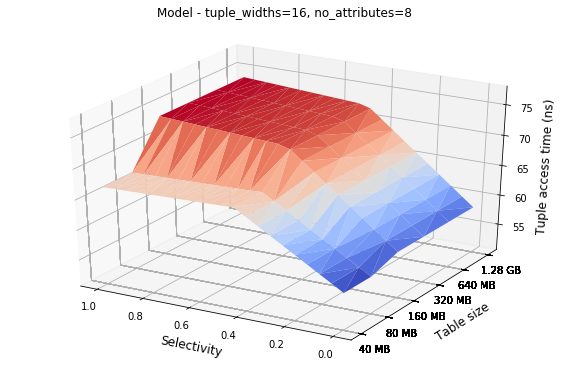

Mean Q Error: 1.0165419283171966


<Figure size 432x288 with 0 Axes>

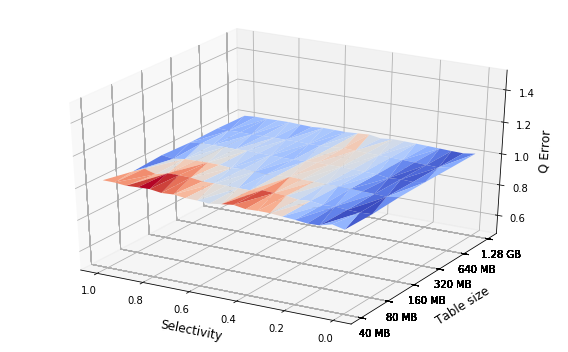

<Figure size 432x288 with 0 Axes>

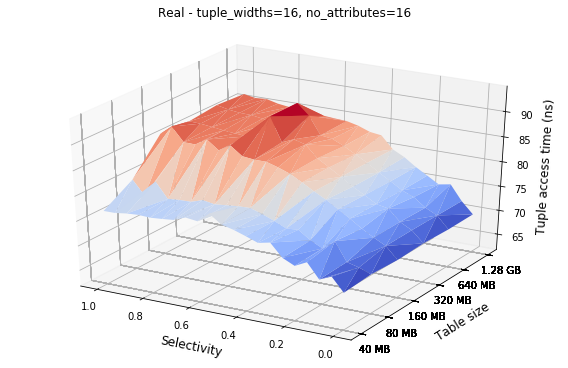

<Figure size 432x288 with 0 Axes>

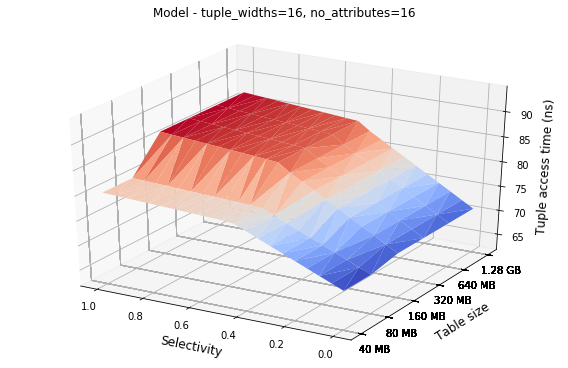

Mean Q Error: 1.0111531626779258


<Figure size 432x288 with 0 Axes>

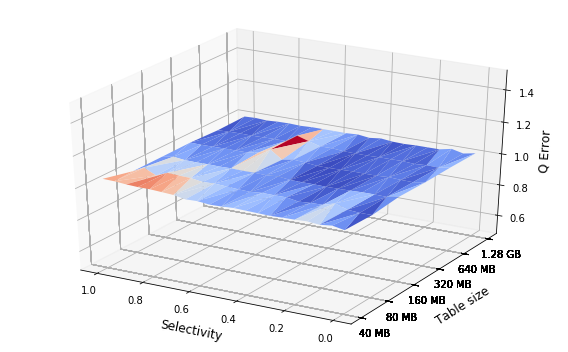

<Figure size 432x288 with 0 Axes>

In [340]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

df = pd.read_csv("data/white_box/simple_sel_pipeline_smaller_tables.csv")

df['tupleaccess'] = (1000*df['runtime']) / df['tablerows']

with open('models/white_box/scan_40k_80k.pickle', 'rb') as handle:
    white_box_params_40_80 = pickle.load(handle)
    
with open('models/white_box/scan_larger_160k.pickle', 'rb') as handle:
    white_box_params_160 = pickle.load(handle)

def estimate_per_row(df_row, model):
    return scan_branched_op(params=model, selectivity=df_row['selectivity'], 
                            tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                            no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()

df['white_box_estimate'] = df.apply(lambda row: (estimate_per_row(row, white_box_params_40_80)) if row['tablesizekb'] < 160000 else (estimate_per_row(row, white_box_params_160)), axis=1)

df['estimated_tupleaccess'] = (1000*df['white_box_estimate']) / df['tablerows']

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()

def plot_it(X, Y, Z_true, Z_est, tw, attrInPred, mode):
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca(projection='3d')
    plt.gca().invert_xaxis()
#             ax.yaxis.set_scale('log')
#             ax.set_ylim(plot_data['tuplewidth'].max(),plot_data['tuplewidth'].min())
    ax.set_zlim(min(min(Z_est), min(Z_true))*0.90, max(max(Z_est), max(Z_true))*1.05)

    plt.tight_layout()

    #Fix Z axis limits for both estimated and measured runtimes
        
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_yticks(np.log2(Y))
    Y = np.log2(Y)
    ax.yaxis.set_major_formatter(major_formatter)

    ax.set_xlabel("Selectivity", labelpad=10, fontsize=12)
    ax.set_ylabel("Table size", labelpad=10, fontsize=12)
    ax.set_zlabel("Tuple access time (ns)", fontsize=12)

        
    if mode == "model":
        Z = Z_est
        plt.title(f"Model - tuple_widths={tw}, no_attributes={attrInPred}")
    elif mode == "realexe":
        Z = Z_true
        plt.title(f"Real - tuple_widths={tw}, no_attributes={attrInPred}")
    elif mode == "qerror":
        Z = np.maximum(Z_est / Z_true, Z_true / Z_est)
        ax.set_zlim(0.5, 1.5)
        ax.set_zlabel("Q Error", fontsize=12)
        print ("Mean Q Error: " + str(Z.mean()))
    
    surf1 = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm)#, alpha=0.7)
    plt.show()
    plt.savefig(f"plots/3d_selectivity_tablesize/3d_selectivity_tablesize_tuple_widths={tw}_no_attributes={attrInPred}_{mode}.pdf", bbox_inches='tight')

    
# for ts in tablesizes:
for tw in tuple_widths:
    df_temp = df[df.tuplewidth == tw]
    df_temp_big = df_temp[df_temp.tablesizekb >= 40000]
    if len(df_temp_big.index) > 0:
        averaged_data = df_temp_big[['attrInPred', 'selectivity', 'tablesizekb', 'tupleaccess', 'white_box_estimate', 'estimated_tupleaccess']].groupby(['attrInPred', 'tablesizekb', 'selectivity']).mean().reset_index()
        for attrInPred in averaged_data['attrInPred'].unique():
            plot_data = averaged_data[averaged_data.attrInPred == attrInPred]
            
            if (len(plot_data['tablesizekb'].unique()) < 2):
                continue
                
            X = plot_data['selectivity']
            Y = plot_data['tablesizekb']
            Z_true = plot_data['tupleaccess']
            Z_est = plot_data['estimated_tupleaccess']
        
            
            plot_it(X, Y, Z_true, Z_est, tw, attrInPred, mode="realexe")
            plot_it(X, Y, Z_true, Z_est, tw, attrInPred, mode="model")
            plot_it(X, Y, Z_true, Z_est, tw, attrInPred, mode="qerror")
            
            
                

tuple_widths=16_selectivity=0.0: Mean Q Error: 1.0138607944786344
tuple_widths=16_selectivity=0.1: Mean Q Error: 1.0112864978938865
tuple_widths=16_selectivity=0.2: Mean Q Error: 1.0119664477206924
tuple_widths=16_selectivity=0.3: Mean Q Error: 1.0124641875651592
tuple_widths=16_selectivity=0.4: Mean Q Error: 1.0146200881950767
tuple_widths=16_selectivity=0.5: Mean Q Error: 1.0183407655631975
tuple_widths=16_selectivity=0.6: Mean Q Error: 1.0139901873300823
tuple_widths=16_selectivity=0.7: Mean Q Error: 1.0195340006811127
tuple_widths=16_selectivity=0.8: Mean Q Error: 1.0163500785824753
tuple_widths=16_selectivity=0.9: Mean Q Error: 1.015224745713613
tuple_widths=16_selectivity=1.0: Mean Q Error: 1.0161621330524269


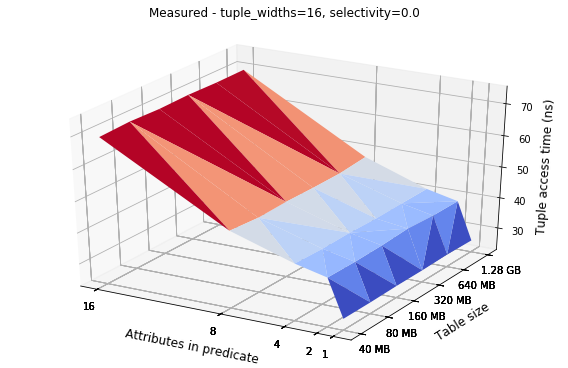

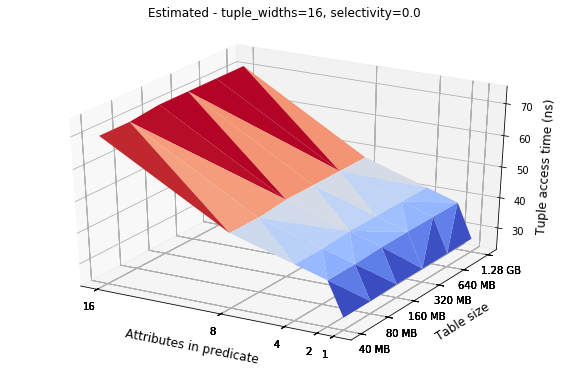

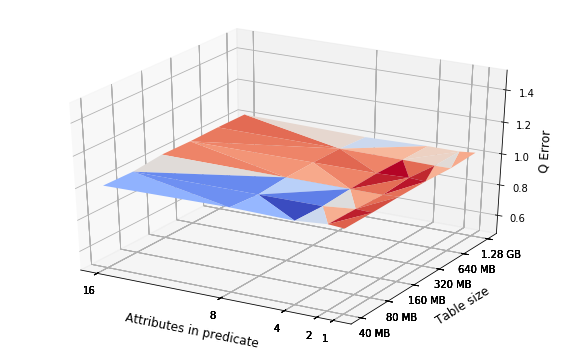

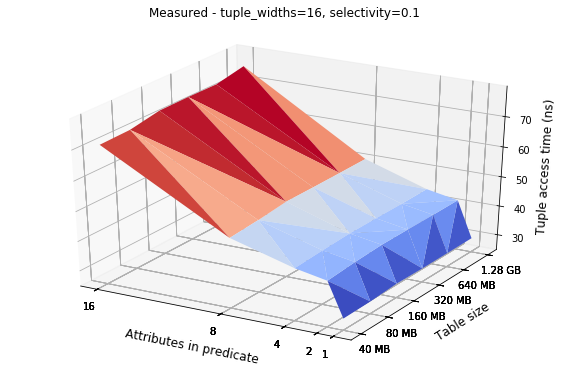

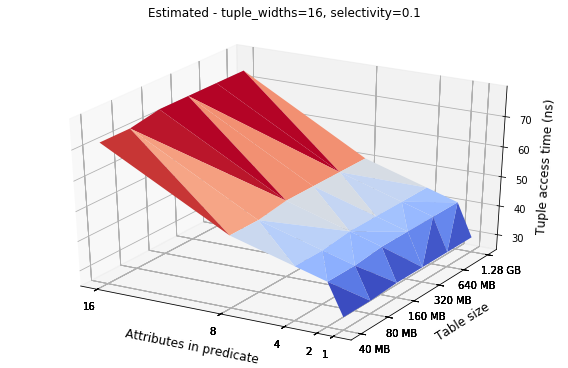

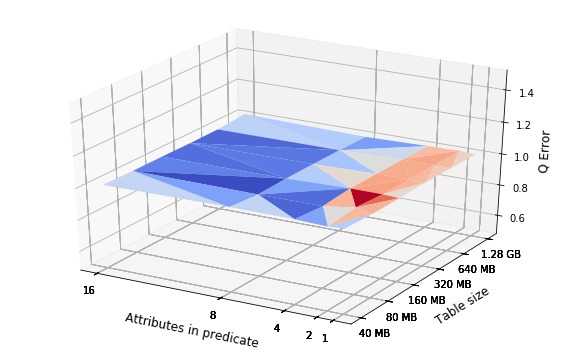

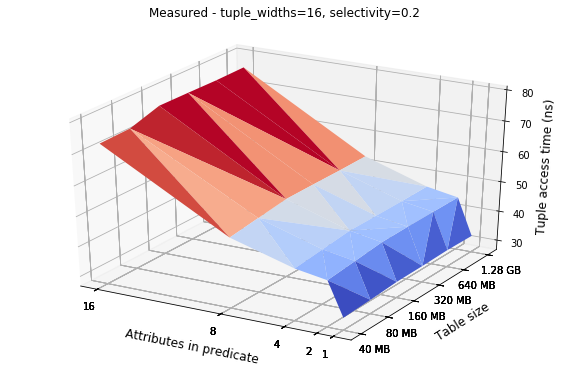

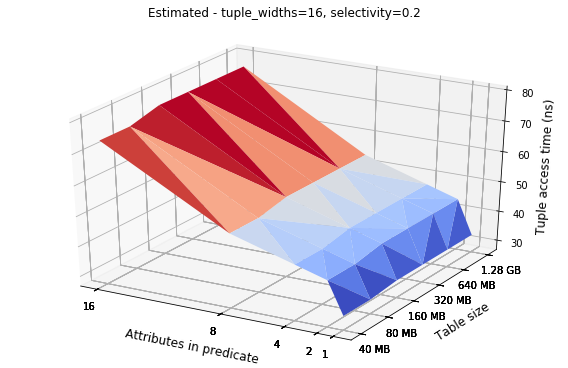

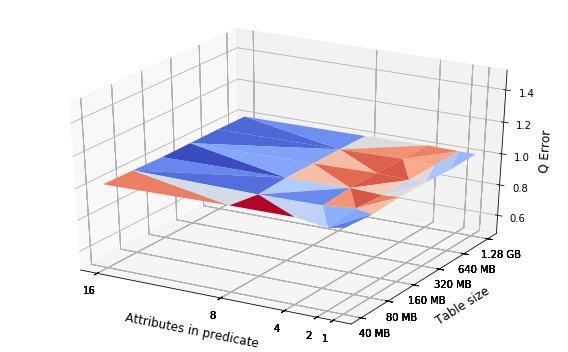

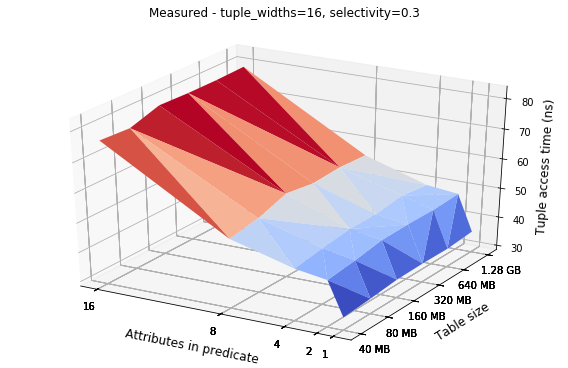

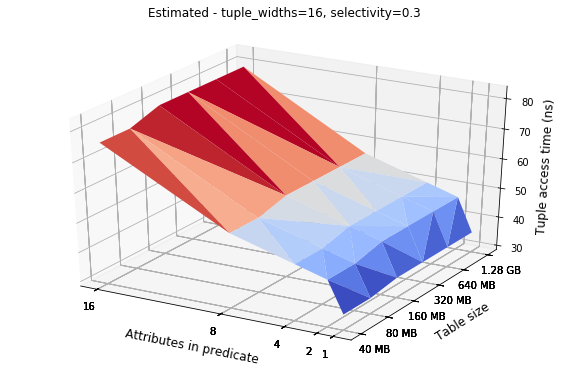

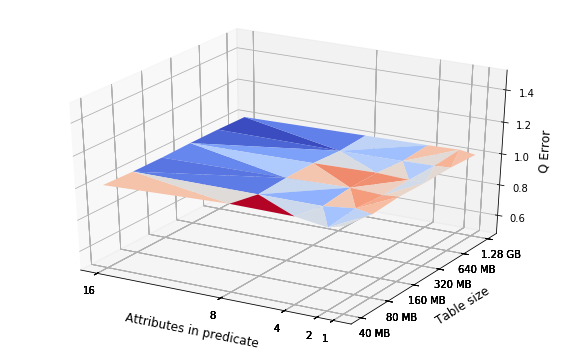

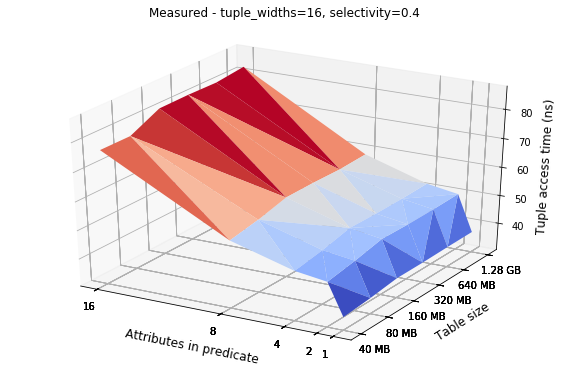

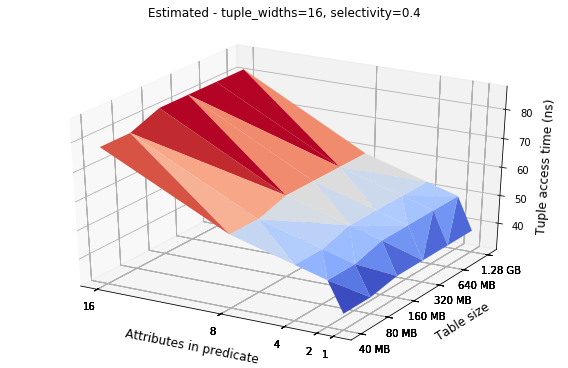

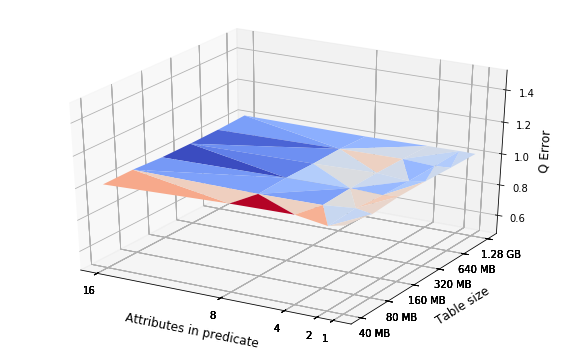

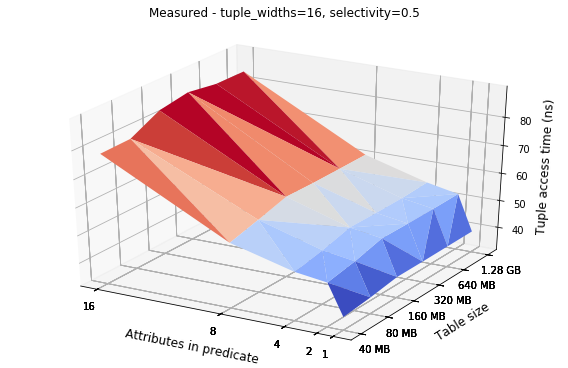

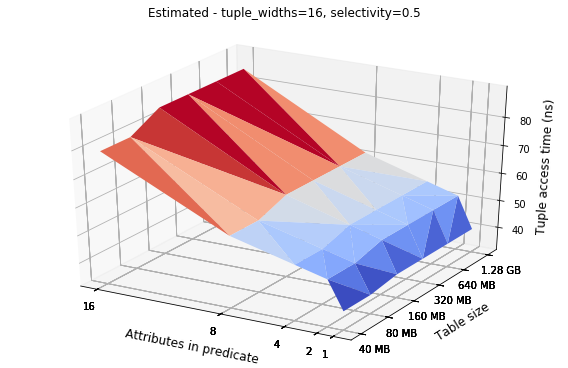

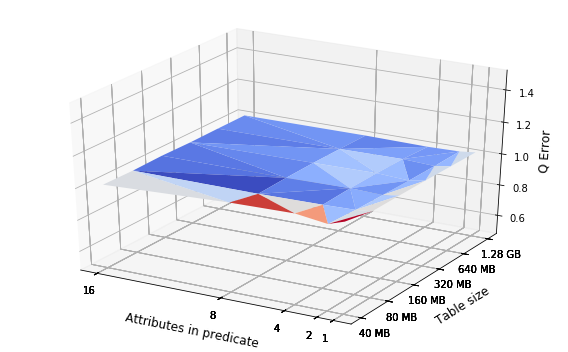

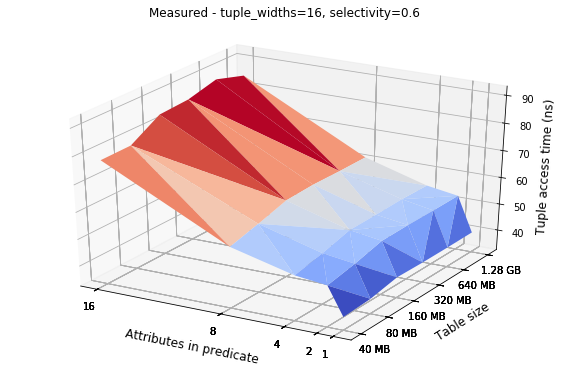

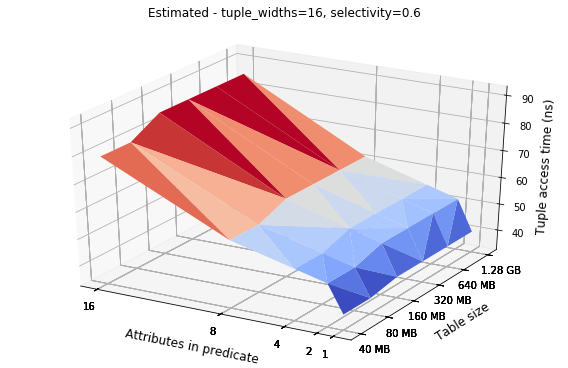

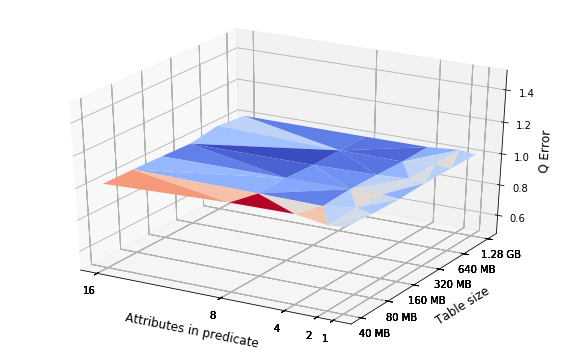

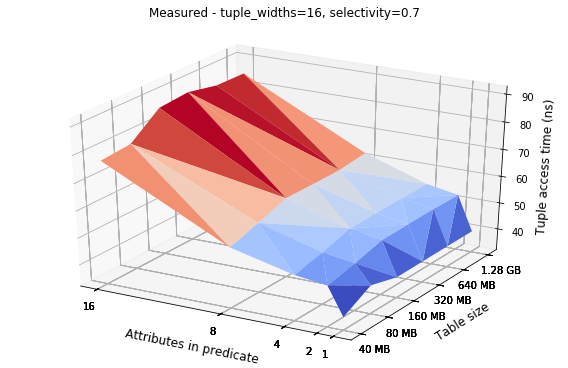

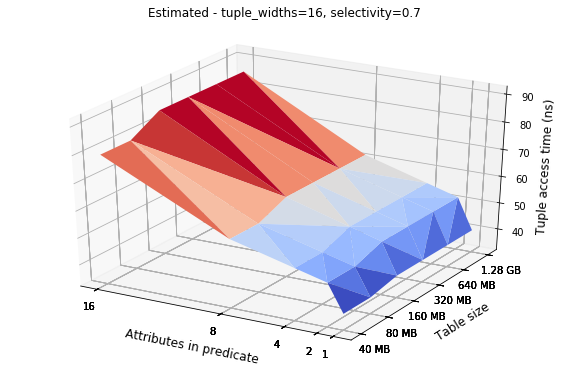

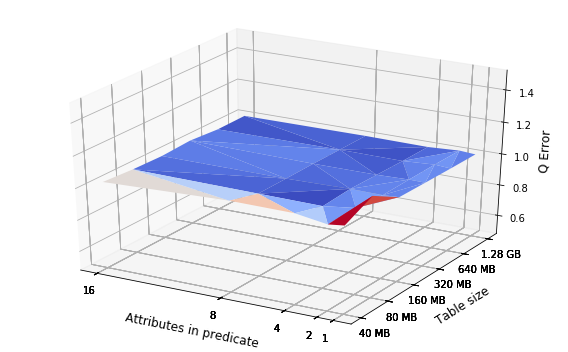

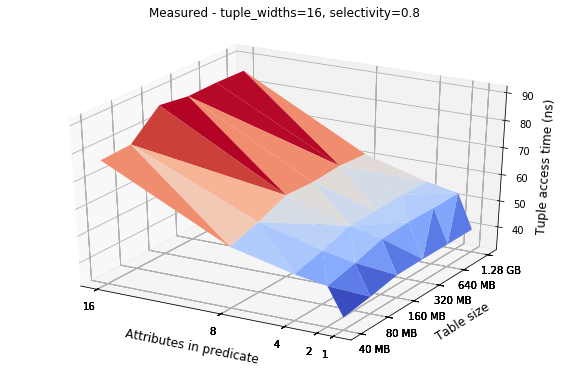

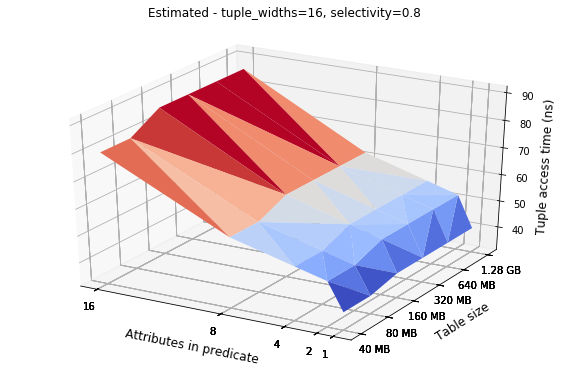

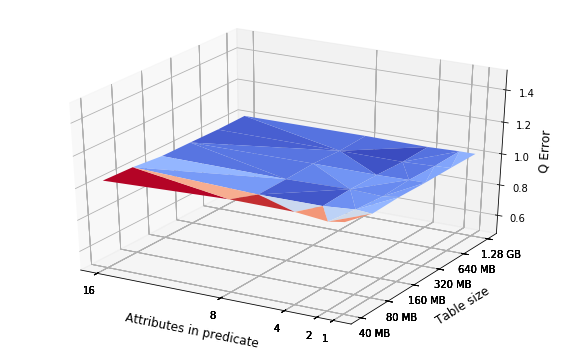

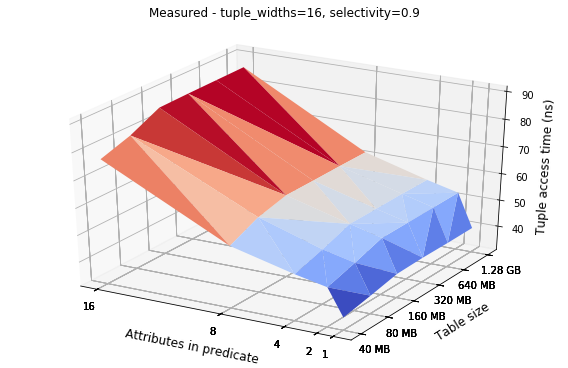

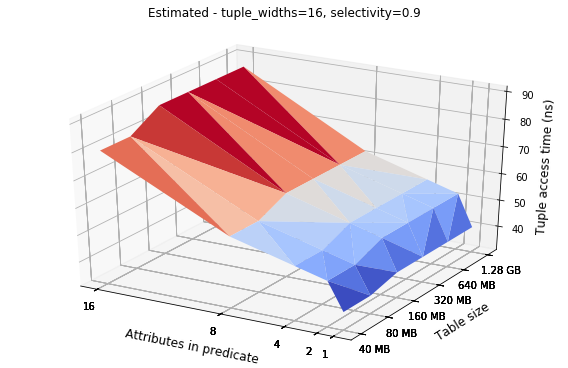

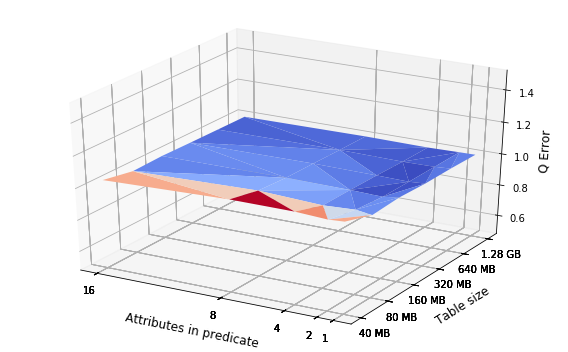

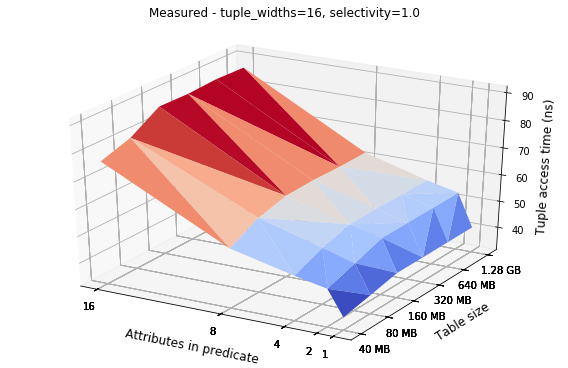

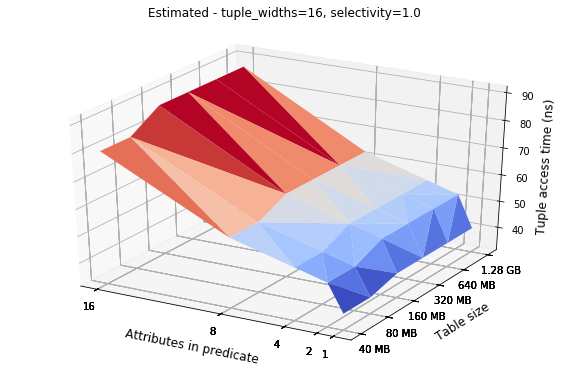

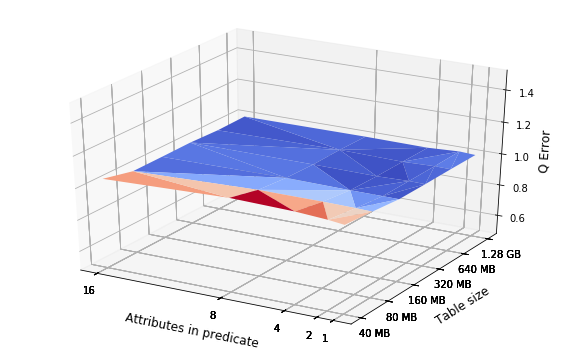

In [349]:
## from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

df = pd.read_csv("data/white_box/simple_sel_pipeline_smaller_tables.csv")

df['tupleaccess'] = (1000*df['runtime']) / df['tablerows']

with open('models/white_box/scan_40k_80k.pickle', 'rb') as handle:
    white_box_params_40_80 = pickle.load(handle)
    
with open('models/white_box/scan_larger_160k.pickle', 'rb') as handle:
    white_box_params_160 = pickle.load(handle)

def estimate_per_row(df_row, model):
    return scan_branched_op(params=model, selectivity=df_row['selectivity'], 
                            tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                            no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()


def plot_it(X, Y, Z_true, Z_est, tw, attrInPred, mode):
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca(projection='3d')
    
    #Fix Z axis limits for both estimated and measured runtimes
    ax.set_zlim(min(min(Z_est), min(Z_true))*0.90, max(max(Z_est), max(Z_true))*1.05)

    plt.tight_layout()

    ax.set_xticks(X)
    ax.set_yticks(np.log2(Y))
    Y = np.log2(Y)
    plt.gca().invert_xaxis()
    ax.yaxis.set_major_formatter(major_formatter)

    ax.set_xlabel("Attributes in predicate", labelpad=10, fontsize=12)
    ax.set_ylabel("Table size", labelpad=10, fontsize=12)
    ax.set_zlabel("Tuple access time (ns)", fontsize=12)

        
    if mode == "est":
        Z = Z_est
        plt.title(f"Estimated - tuple_widths={tw}, selectivity={selectivity}")
    elif mode == "true":
        Z = Z_true
        plt.title(f"Measured - tuple_widths={tw}, selectivity={selectivity}")
    elif mode == "qerror":
        Z = np.maximum(Z_est / Z_true, Z_true / Z_est)
        ax.set_zlim(0.5, 1.5)
        ax.set_zlabel("Q Error", fontsize=12)
        print (f"tuple_widths={tw}_selectivity={selectivity}: Mean Q Error: " + str(Z.mean()))
        
    
    surf1 = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm)#, alpha=0.7)
#     plt.show()
    plt.savefig(f"plots/3d_attributes_tablesize/3d_attributes_tablesize_tuple_widths={tw}_selectivity={selectivity}_{mode}.pdf", bbox_inches='tight')


df['white_box_estimate'] = df.apply(lambda row: (estimate_per_row(row, white_box_params_40_80)) if row['tablesizekb'] < 160000 else (estimate_per_row(row, white_box_params_160)), axis=1)

df['estimated_tupleaccess'] = (1000*df['white_box_estimate']) / df['tablerows']

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()
# print (tablesizes)
# for ts in tablesizes:
# for tw in tuple_widths:
df_temp = df
df_temp_big = df_temp[df_temp.tablesizekb >= 40000]
if len(df_temp_big.index) > 0:
    averaged_data = df_temp_big[['attrInPred', 'selectivity', 'tablesizekb', 'tupleaccess', 'white_box_estimate', 'estimated_tupleaccess']].groupby(['attrInPred', 'tablesizekb', 'selectivity']).mean().reset_index()
    selectivities = averaged_data['selectivity'].round(1).unique()
    for selectivity in selectivities[::1]:
        plot_data = averaged_data[averaged_data.selectivity == selectivity]
        
        X = plot_data['attrInPred']
        Y = plot_data['tablesizekb']
        Z_true = plot_data['tupleaccess']
        Z_est = plot_data['estimated_tupleaccess']

        plot_it(X, Y, Z_true, Z_est, tw, selectivity, mode="true")
        plot_it(X, Y, Z_true, Z_est, tw, selectivity, mode="est")
        plot_it(X, Y, Z_true, Z_est, tw, selectivity, mode="qerror")
                
                

## White Box Generalization - 1c

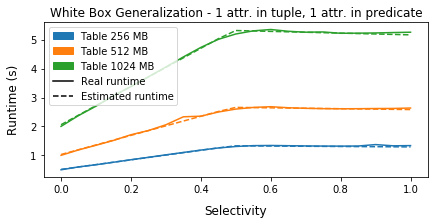

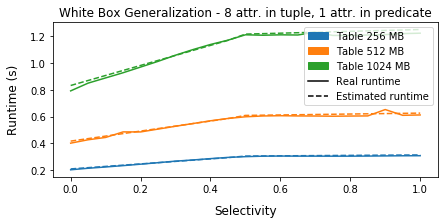

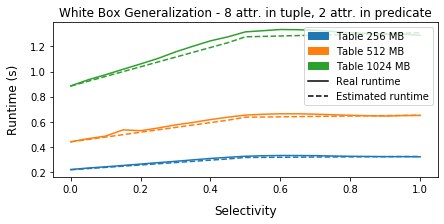

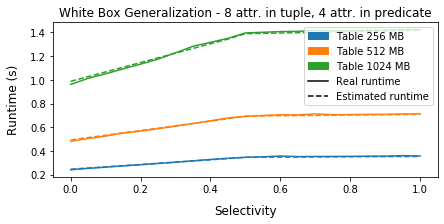

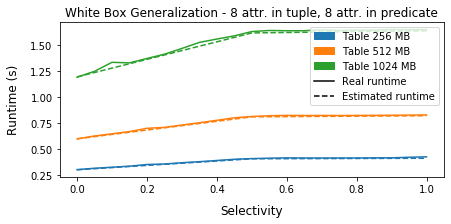

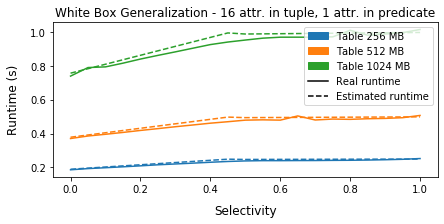

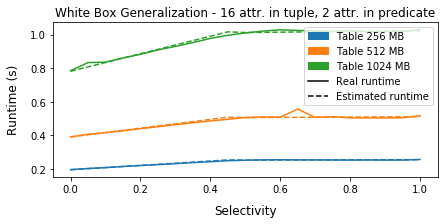

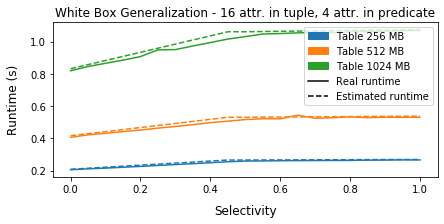

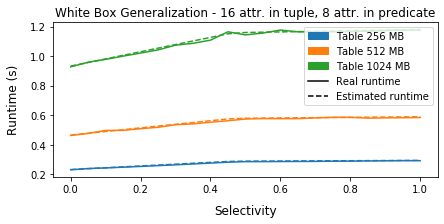

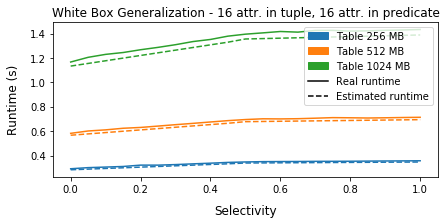

In [344]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df = pd.read_csv("data/simple_sel_pipeline_new_tablesizes.csv")
plt.rcParams.update({'figure.max_open_warning': 0})

with open('models/white_box/scan_larger_160k.pickle', 'rb') as handle:
    white_box_params = pickle.load(handle)

def estimate_per_row(df_row):
    return scan_branched_op(params=white_box_params, selectivity=df_row['selectivity'], 
                            tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                            no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()

df['white_box_estimate'] = df.apply(estimate_per_row, axis=1)

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()

# 160 320 640 1280
#      x
# .    x .     x
#              x
# Collect new runtimes for new parameters and show 3 runtimes in one plots
# 
# for ts in tablesizes:
for tw in tuple_widths:
    df_temp_big = df.query("tuplewidth == " + str(tw) )
    if len(df_temp_big.index) > 0:
        averaged_data = df_temp_big[['attrInPred', 'selectivity', 'runtime', 'white_box_estimate', 'tablesizekb']].groupby(['attrInPred', 'selectivity', 'tablesizekb']).mean().reset_index()
        for attrInPred in averaged_data['attrInPred'].unique():
            plot_data = averaged_data[averaged_data.attrInPred == attrInPred]

            plt.figure(figsize=figsize())
            plt.title(f"White Box Generalization - {tw} attr. in tuple, {attrInPred} attr. in predicate")
            i = 0
            legends = []

            for ts in tablesizes:
                plot_table_data = plot_data[plot_data.tablesizekb == ts]
                
                plt.plot(plot_table_data['selectivity'], plot_table_data['runtime']/1000000, linestyle='-', color=plt.cm.tab10(i))
                plt.plot(plot_table_data['selectivity'], plot_table_data['white_box_estimate']/1000000,  linestyle='--', color=plt.cm.tab10(i))

                legends.append(mpatches.Patch(color=plt.cm.tab10(i), label="Table " + str(int(ts/1000)) + " MB"))
                i += 1
            plt.xlabel("Selectivity", labelpad=10, fontsize=12)
            plt.ylabel("Runtime (s)", labelpad=10, fontsize=12)
            
            legends.append(mlines.Line2D([], [], color='black', label='Real runtime'))
            legends.append(mlines.Line2D([], [], linestyle='--', color='black', label='Estimated runtime'))
            
            plt.legend(handles=legends)
            plt.savefig(f"plots/white-box-generalization/exp3_w{tw}_a{attrInPred}.pdf", bbox_inches='tight')

            
            
            

In [326]:
# Add runtimes from build and probe pipelines...

df_build = pd.read_csv("data/build_pipeline.csv")
df_probe = pd.read_csv("data/probe_pipeline.csv")

df_combined = df_build
df_combined['runtime'] = df_build['runtime'] + df_probe['runtime']

# #export to csv
df_combined.to_csv( "data/join_query.csv", index=False, encoding='utf-8-sig')

